# Contoh Klasifikasi

In [101]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

import seaborn as sns


In [102]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [103]:
x = iris_data.data
y = iris_data.target

In [104]:
from sklearn.preprocessing import MinMaxScaler
x = MinMaxScaler().fit_transform(x)

In [105]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_x, test_x, train_y, test_y = train_test_split(
    x, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

### Parameterized Circuit: Feature Map Buatan Sendiri
- Perhatikah bahwa : Jumlah qubit harus sama dengan jumlah fitur

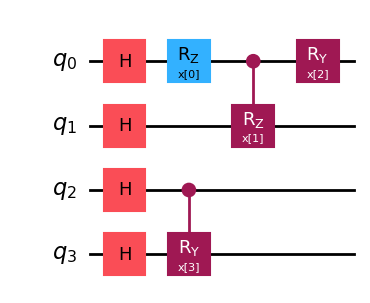

In [106]:
jum_fitur = x.shape[1]
theta_list = ParameterVector('x', length=jum_fitur)

feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h([0,1,2,3])
feature_map_1.rz(theta_list[0], 0)
feature_map_1.crz(theta_list[1], 0, 1)
feature_map_1.ry(theta_list[2], 0)
feature_map_1.cry(theta_list[3], 2, 3)
feature_map_1.draw('mpl')

### Parameterized Circuit: Feature Map menggunakan Library di Qiskit

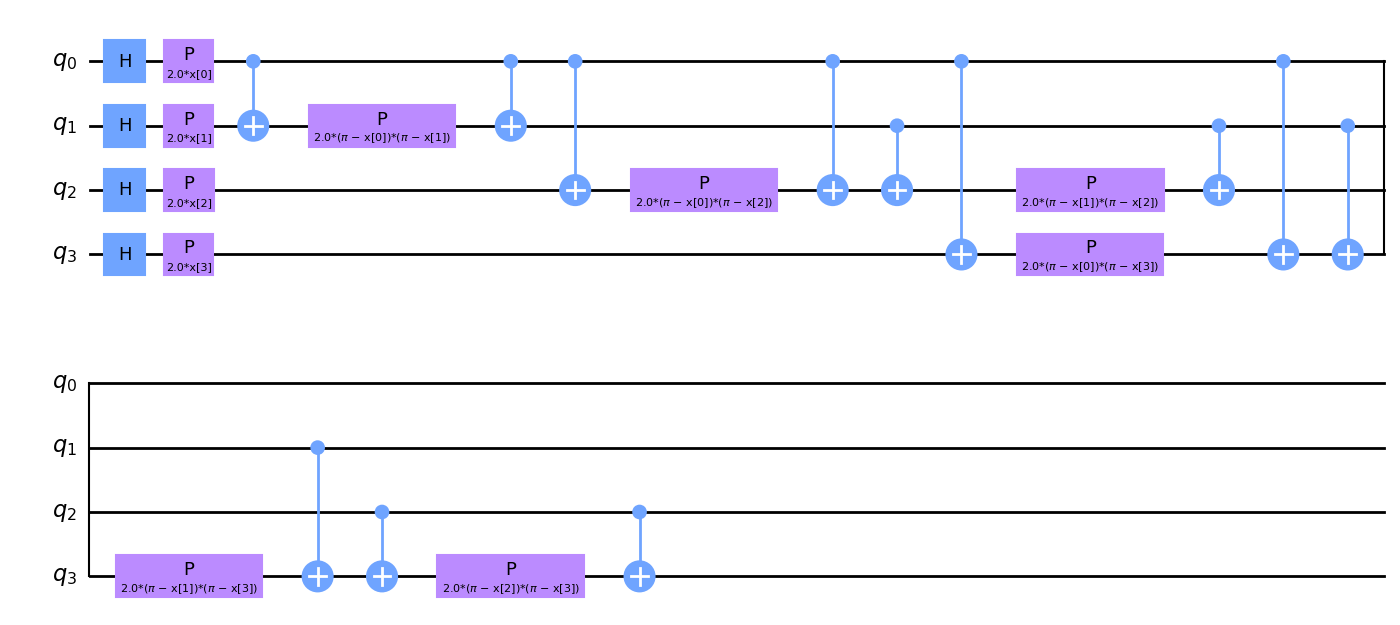

In [107]:
from qiskit.circuit.library import ZZFeatureMap

jum_fitur = x.shape[1]

feature_map_2 = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
feature_map_2.decompose().draw(output="mpl", style="clifford", fold=20)

### Parameterized Circuit: Ansatz Buatan Sendiri

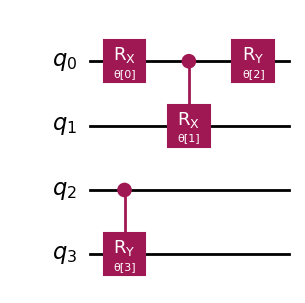

In [108]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.ry(theta_list[2], 0)
ansatz_1.cry(theta_list[3], 2, 3)
ansatz_1.draw('mpl')

### Parameterized Circuit: Anzats menggunakan Library di Qiskit

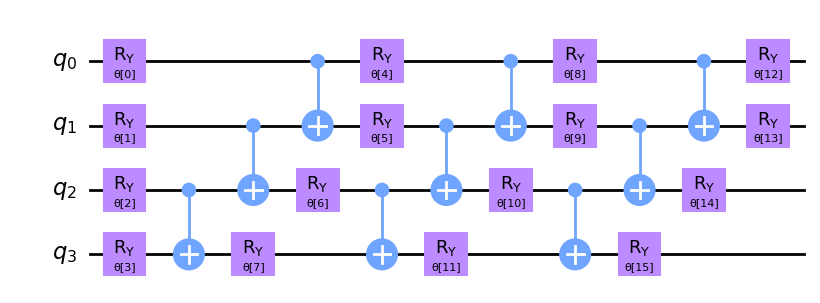

In [109]:
from qiskit.circuit.library import RealAmplitudes

ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)
ansatz_2.decompose().draw(output="mpl", style="clifford", fold=20)

In [110]:
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [111]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

### Fungsi untuk menggambar proses pelatihan

In [112]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Nilai fungsi objektif terhadap iterasi")
    plt.xlabel("Iterasi")
    plt.ylabel("Nilai fungsi objektif")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Pelatihan VQC

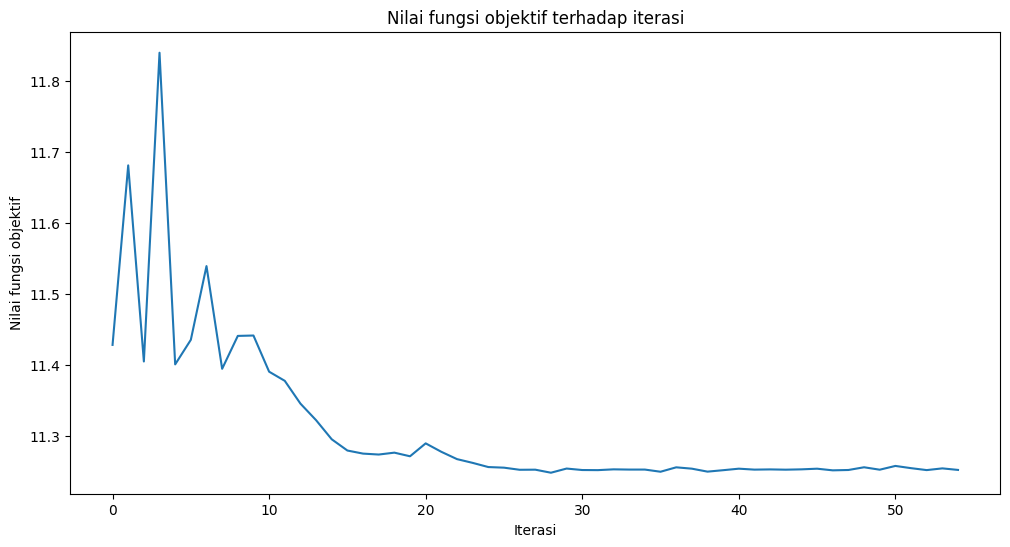

Waktu Training : 20 detik


In [113]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,  # sebagai alternatif: feature_map_2
    ansatz=ansatz_1,            # sebagai alternatif: ansatz_2
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai oyektif 
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training : {round(elapsed)} detik")

Mari kita lihat bagaimana model kuantum bekerja pada kumpulan data kehidupan nyata.

In [114]:
score_pelatihan_1 = vqc.score(train_x, train_y)
score_pengujian_1 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan: {score_pelatihan_1:.2f}")
print(f"VQC kuantum pada dataset uji      : {score_pengujian_1:.2f}")

VQC kuantum pada dataset pelatihan: 0.68
VQC kuantum pada dataset uji      : 0.63


## 4. Mengurangi Jumlah Fitur menggunakan PCA

<Axes: >

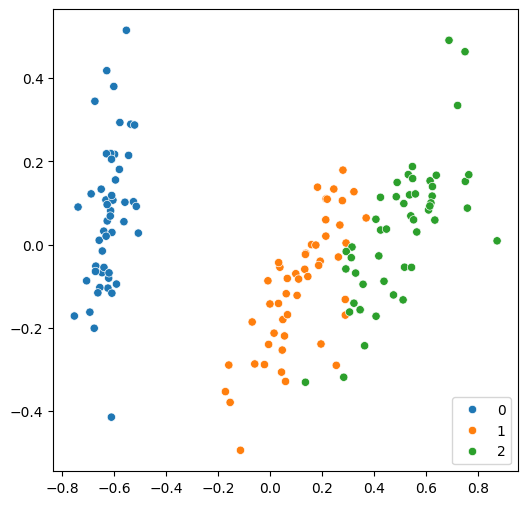

In [115]:
from sklearn.decomposition import PCA
jum_fitur = 2
x_PCA = PCA(n_components=jum_fitur).fit_transform(x)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=x_PCA[:, 0], y=x_PCA[:, 1], hue=y, palette="tab10")

In [116]:
train_x, test_x, train_y, test_y = train_test_split(
    x_PCA, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

### Parameterized Circuit: Feature Map Buatan Sendiri

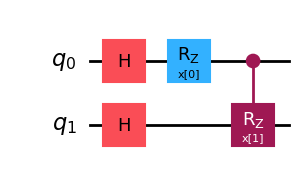

In [117]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit

theta_list = ParameterVector('x', length=jum_fitur)

feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h([0,1])
feature_map_1.rz(theta_list[0], 0)
feature_map_1.crz(theta_list[1], 0, 1)
feature_map_1.draw('mpl')

### Parameterized Circuit: Ansatz Buatan Sendiri

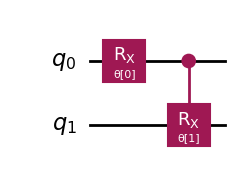

In [118]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.draw('mpl')

In [119]:
feature_map_2 = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)

In [120]:
optimizer = COBYLA(maxiter=100)

Sekarang kita membangun pengklasifikasi kuantum dari parameter baru dan melatihnya.

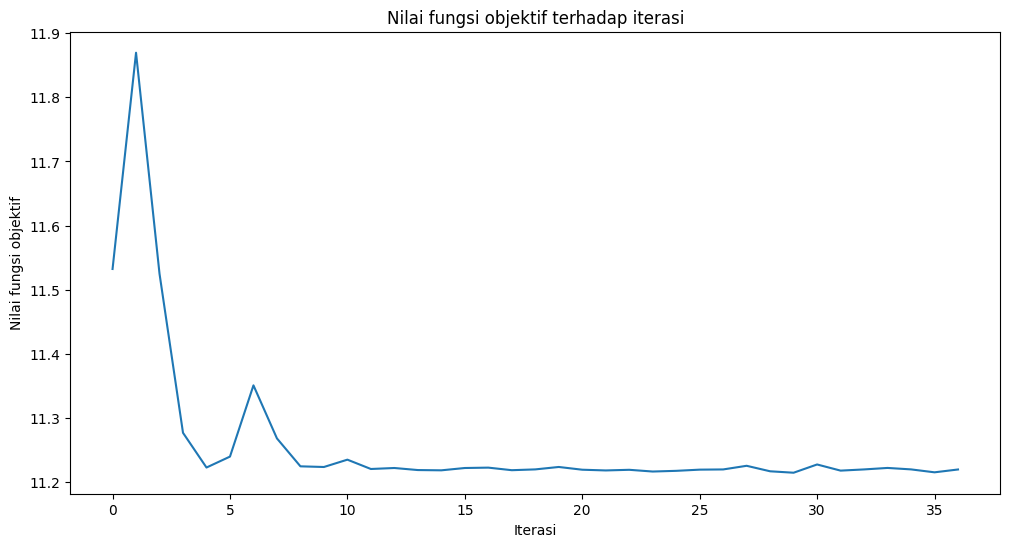

Waktu Training: 11 detik


In [121]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,
    ansatz=ansatz_1,
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai obyektif
objective_func_vals = []

# membuat plot fungsi objektif terlihat lebih bagus.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [122]:
score_pelatihan_2 = vqc.score(train_x, train_y)
score_pengujian_2 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: {score_pelatihan_2:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan RealAmplitudes      : {score_pengujian_2:.2f}")

VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: 0.61
VQC kuantum pada dataset uji menggunakan RealAmplitudes      : 0.63


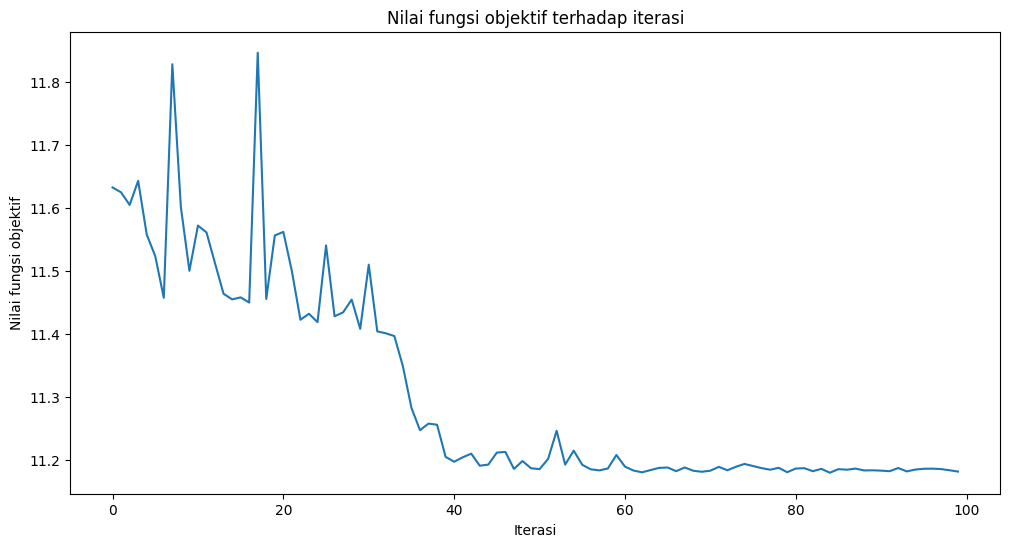

Waktu Training: 38 detik


In [123]:
from qiskit.circuit.library import EfficientSU2

ansatz_2 = EfficientSU2(num_qubits=jum_fitur, reps=3)
optimizer = COBYLA(maxiter=100)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,
    ansatz=ansatz_2,               #  pakai anzats baru
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [124]:
score_pelatihan_3 = vqc.score(train_x, train_y)
score_pengujian_3 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: {score_pelatihan_3:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan EfficientSU2      : {score_pengujian_3:.2f}")

VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: 0.68
VQC kuantum pada dataset uji menggunakan EfficientSU2      : 0.63


## 5. Kesimpulan

Dalam tutorial ini, kami telah membangun dua model pembelajaran mesin klasik dan tiga model pembelajaran mesin kuantum. Mari kita cetak tabel keseluruhan dengan hasil kami.

In [125]:
print(f"Model                     | Score Pelatihan | Score Pengujian")
print(f"VQC, 4 features, Anzats_1 | {score_pelatihan_1:10.2f} | {score_pengujian_1:10.2f}")
print(f"VQC, 2 features, Anzats_1 | {score_pelatihan_2:10.2f} | {score_pengujian_2:10.2f}")
print(f"VQC, 2 features, Anzats_2 | {score_pelatihan_3:10.2f} | {score_pengujian_3:10.2f}")

Model                     | Score Pelatihan | Score Pengujian
VQC, 4 features, Anzats_1 |       0.68 |       0.63
VQC, 2 features, Anzats_1 |       0.61 |       0.63
VQC, 2 features, Anzats_2 |       0.68 |       0.63
